**Timeseries Machine Learning by Mahmudin Rizal (Mahmudinrizal11@gmail.com)**

Dataset berasal dari kaggle (https://www.kaggle.com/srinuti/residential-power-usage-3years-data-timeseries?select=power_usage_2016_to_2020.csv)

In [1]:
from datetime import datetime, date
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

**Data Preparation**

In [2]:
df = pd.read_csv('power_usage_2016_to_2020.csv')
df.head()

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday


In [3]:
df.shape

(35952, 4)

In [4]:
df.isnull().sum()

StartDate      0
Value (kWh)    0
day_of_week    0
notes          0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StartDate    35952 non-null  object 
 1   Value (kWh)  35952 non-null  float64
 2   day_of_week  35952 non-null  int64  
 3   notes        35952 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ MB


In [6]:
df.rename(columns={"StartDate": "Datetime"}, inplace=True)

In [7]:
df['Datetime']= pd.to_datetime(df['Datetime'])
df = df[['Datetime','Value (kWh)' ]]
df.head()

,Datetime,Value (kWh)
0,2016-01-06 00:00:00,1.057
1,2016-01-06 01:00:00,1.171
2,2016-01-06 02:00:00,0.560
3,2016-01-06 03:00:00,0.828
4,2016-01-06 04:00:00,0.932


In [8]:
df['Datetime'] = df['Datetime'].dt.date

In [9]:
df_baru = df.copy()
df_baru.head()

,Datetime,Value (kWh)
0,2016-01-06,1.057
1,2016-01-06,1.171
2,2016-01-06,0.560
3,2016-01-06,0.828
4,2016-01-06,0.932


In [10]:
df_baru = df_baru.set_index('Datetime')
df_baru.head()

,Value (kWh)
Datetime,
2016-01-06,1.057
2016-01-06,1.171
2016-01-06,0.560
2016-01-06,0.828
2016-01-06,0.932


**Plot Data Awal**

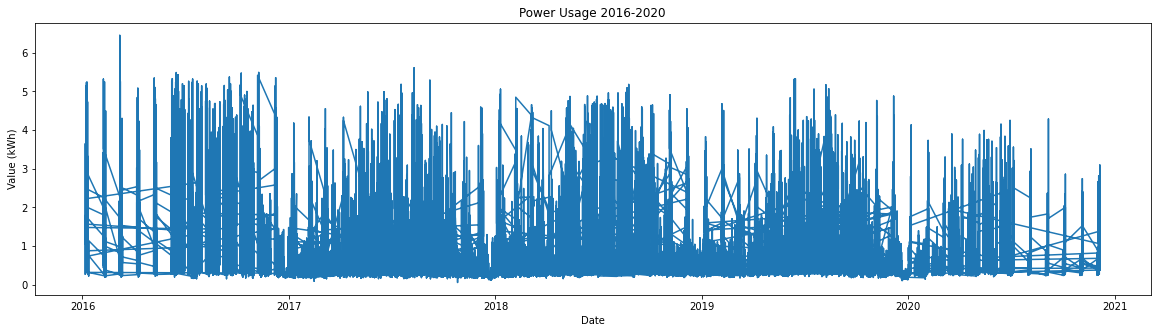

In [11]:
plt.figure(figsize=(20,5))
plt.plot(df_baru)
plt.title('Power Usage 2016-2020')
plt.xlabel('Date')
plt.ylabel('Value (kWh)')
plt.show()

**Membuat Model**

In [12]:
Date = df['Datetime'].values
Value = df['Value (kWh)'].values

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [14]:
value_train, value_test, y_train, y_test = train_test_split(Value, Date, test_size = 0.2, random_state = 42 )

In [40]:
tf.keras.backend.clear_session()

train_set = windowed_dataset(value_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(value_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model_ts = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True,),
  tf.keras.layers.LSTM(30),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [41]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model_ts.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [31]:
data_scale10 = (df['Value (kWh)'].max() - df['Value (kWh)'].min()) * (9 / 100)
data_scale10

0.5743800000000001

In [34]:
# callbacks for early stop when reach our target accuracy
accuracy_threshold = 93e-2
class our_callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if (logs.get('mae')< data_scale10):
            print('\nFor Epoch', epoch, '\nmae < 9% Data Scale. Training has been stopped. Continue to next step')
            self.model.stop_training = True

In [42]:
history = model_ts.fit(train_set ,
                    epochs=50,  
                    callbacks=[our_callbacks()],
                    validation_data = test_set,
                    verbose=1)

Epoch 1/50
288/288 [==============================] - 37s 96ms/step - loss: 0.4447 - mae: 0.7516 - val_loss: 0.3554 - val_mae: 0.5847
Epoch 2/50
288/288 [==============================] - 27s 94ms/step - loss: 0.3404 - mae: 0.5792 - val_loss: 0.3014 - val_mae: 0.5513
Epoch 3/50
288/288 [==============================] - 27s 93ms/step - loss: 0.3081 - mae: 0.5726 - val_loss: 0.2879 - val_mae: 0.5688

For Epoch 2 
mae < 9% Data Scale. Training has been stopped. Continue to next step


**Plot MAE dan loss**

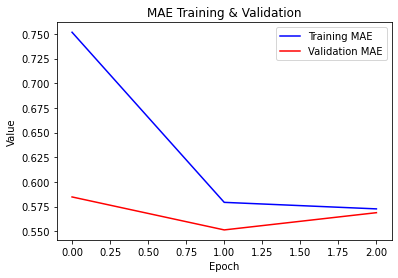

In [44]:
plt.plot(history.history['mae'], label='Training MAE', color='blue')
plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
plt.title('MAE Training & Validation')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

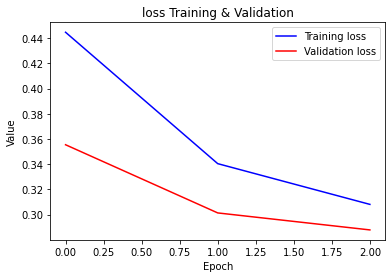

In [45]:
plt.plot(history.history['loss'], label='Training loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation loss', color='red')
plt.title('loss Training & Validation')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()